# [12_Types_Specialisation](../12_Types_Specialisation.ipynb)

1. It only needs to store the length and the position of the one-bit.

2. A possible definition of the type is:

In [ ]:
struct OneHot
    len::Int  # Length
    ind::Int  # Index of the one-bit
end 

3. To support the indicated piece of code we need the following functions frome base:

In [ ]:
import Base: *, getindex, length

length(v::OneHot) = v.len
getindex(v::OneHot, i::Int) = i == v.ind
*(A::AbstractMatrix, v::OneHot) = A[:, v.ind]

4. We benchmark the `innersum` for both indicated cases:

In [ ]:
function innersum(A, vs)
    t = zero(eltype(A))
    for v in vs
        y = A * v
        for i in 1:length(vs[1])
            t += v[i] * y[i]
        end
    end
    t
end

In [ ]:
using BenchmarkTools
A = rand(3, 3)
vs_float  = [rand(3)              for i in 1:10]
vs_onehot = [OneHot(3, rand(1:3)) for _ in 1:10]

@btime innersum($A, $vs_float);
@btime innersum($A, $vs_onehot);

In my benchmarks the speedup is about a factor of 2.

5. One way to define the `OneHotVector`:

In [ ]:
struct OneHotVector <: AbstractVector{Bool}
    len::Int
    ind::Int
end

Base.getindex(v::OneHotVector, i::Integer) = i == v.ind
Base.size(v::OneHotVector) = (v.len, )

6. Creating a single vector works ...

In [ ]:
OneHotVector(5, 3)

... and gives us a nice visualisation. Also, without any additional effort, the `innersum` just works:

In [ ]:
A  = rand(3, 3)
vs = [OneHotVector(3, rand(1:3)) for _ in 1:10]

innersum(A, vs)

# [14_Exploring_Algorithmic_Differentiation](../14_Exploring_Algorithmic_Differentiation.ipynb)

1. Confirm that `babylonian_sqrt` converges to $\sqrt{x}$ by comparing it with Julia's standard `sqrt` function. As a reference compute `sqrt(big"2.0")`, then compute `sqrt_babylonian` for `N=1` to `N=10`.
    * What is the error of `babylonian_sqrt` against the reference in each case?
    * Plot the absolute error (note the `abs` function) on a semilog scale versus `N` (use the `Plots` package and pass the kwarg `yaxis=:log` to the `plot` function)
    * Does increasing `N` reduce the error?
    * How can you get a more accurate answer without changing the implementation of `babylonian_sqrt`?
    * Why is `sqrt(big"2.0")` a good reference in the first place?

In [1]:
function babylonian_sqrt(x; N=10)
    t = (1 + x) / 2
    for i = 2:N
        t = (t + x / t) / 2
    end
    t
end

babylonian_sqrt (generic function with 1 method)

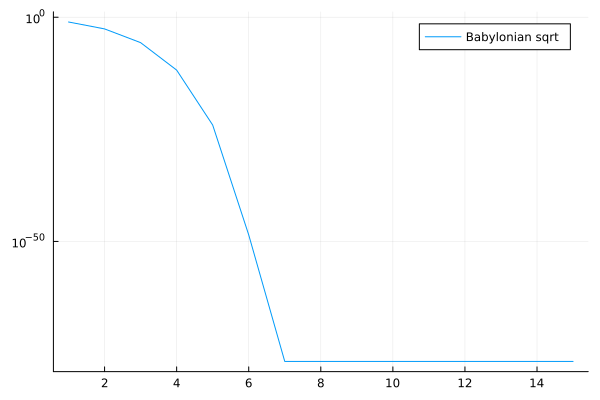

In [14]:
using Plots

Nmax = 15
errors = [abs(babylonian_sqrt(big"2.0"; N) - sqrt(big"2.0")) for N in 1:Nmax]
plot(1:Nmax, errors, label="Babylonian sqrt", yaxis=:log)

2. Do the same thing as in 1., but using a different data type for the input number, try `Float16`, `Float32`, `Float64`, and `BigFloat` and again vary `N`. Plot the error against the reference for all data types in one plot (use the `plot!` function to add another plot to an existing canvas).

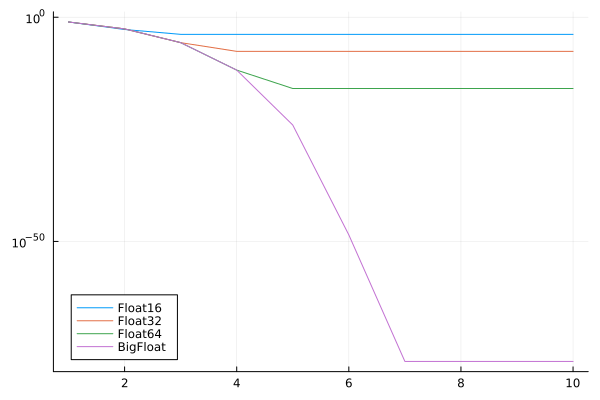

In [16]:
using Plots

Nmax = 10
p = plot(; yaxis=:log, legend=:bottomleft)
reference = sqrt(big"2.0")
for (i, T) in enumerate((Float16, Float32, Float64, BigFloat))
    probe  = T(big"2.0")
    errors = [abs(reference - babylonian_sqrt(probe; N)) for N in 1:Nmax]
    plot!(p, 1:Nmax, errors; label=string(T), m=:x, color=i)
    hline!(p, [eps(T)]; color=i, ls=:dash, label="eps($T)")
end
p

In [17]:
struct Dual <: Number
    x::Float64   # Value
    δx::Float64  # Derivative
end

# Implementation of basic derivative rules:
Base.:+(a::Dual, b::Dual) = Dual(a.x + b.x, a.δx + b.δx)
Base.:-(a::Dual, b::Dual) = Dual(a.x - b.x, a.δx - b.δx)
Base.:*(a::Dual, b::Dual) = Dual(a.x * b.x,  a.x * b.δx + a.δx * b.x )
Base.:/(a::Dual, b::Dual) = Dual(a.x / b.x, (b.x * a.δx - a.x  * b.δx) / b.x^2)

# Handling type conversion
Base.convert(::Type{Dual}, x::Real) = Dual(x, zero(x))
Base.promote_rule(::Type{Dual}, ::Type{<:Number}) = Dual

# Our derivative function
derivative(f::Function, x::Number) = f(Dual(x, one(x))).δx

derivative (generic function with 1 method)

3. Compare `derivative(babylonian_sqrt, some_number)` against the correct analytical derivative of $\sqrt{x}$ at this point. Does it give the correct derivative?

In [26]:
dsqrt(x) = 1 / 2sqrt(x)  # Analytical derivative

for x in [2.0, 3.0, 5.0]
    println("x = $x   diff = ", derivative(babylonian_sqrt, x) - dsqrt(x))
end

x = 2.0   diff = 0.0
x = 3.0   diff = -5.551115123125783e-17
x = 5.0   diff = 0.0



4. Try `derivative` on other functions or algorithms. For example code up a recursive exponentiation function like

In [27]:
pow(x, n) = n <= 0 ? one(x) : x * pow(x, n - 1)

pow (generic function with 1 method)

In [32]:
autodiff = derivative(x -> pow(x, 4), 2.0)
exact = 4 * 2.0^3

@show autodiff exact;

autodiff = 32.0
exact = 32.0


$$
\text{babylonian_sqrt}(x; N=4) \approx \begin{equation}
\frac{\frac{1}{32768} + \frac{15}{4096} x + \frac{455}{8192} x^{2} + \frac{15}{4096} x^{7} + \frac{455}{8192} x^{6} + \frac{1001}{4096} x^{3} + \frac{6435}{16384} x^{4} + \frac{1001}{4096} x^{5} + \frac{1}{32768} x^{8}}{\left( \frac{1}{2} + \frac{1}{2} x \right) \left( \frac{1}{8} + \frac{1}{8} x^{2} + \frac{3}{4} x \right) \left( \frac{1}{128} + \frac{1}{128} x^{4} + \frac{7}{32} x + \frac{35}{64} x^{2} + \frac{7}{32} x^{3} \right)}
\end{equation}
$$

5. Is this formula correct?
    - Hint: Use the `Symbolics` package, in particular `@variables x` and `simplify`.
    - Note: Make sure you have `N=4` since for larger `N` problems might start to occur.

In [34]:
using Symbolics
@variables x

for i in 1:4
    display(babylonian_sqrt(x; N=i))
end

(1//2) + (1//2)*x

(1//4) + (1//4)*x + ((1//2)*x) / ((1//2) + (1//2)*x)

(1//8) + (1//8)*x + ((1//4)*x) / ((1//2) + (1//2)*x) + ((1//2)*x) / ((1//4) + (1//4)*x + ((1//2)*x) / ((1//2) + (1//2)*x))

(1//16) + (1//16)*x + ((1//8)*x) / ((1//2) + (1//2)*x) + ((1//4)*x) / ((1//4) + (1//4)*x + ((1//2)*x) / ((1//2) + (1//2)*x)) + ((1//2)*x) / ((1//8) + (1//8)*x + ((1//4)*x) / ((1//2) + (1//2)*x) + ((1//2)*x) / ((1//4) + (1//4)*x + ((1//2)*x) / ((1//2) + (1//2)*x)))

In [36]:
simplify(babylonian_sqrt(x; N=4))

((1//32768) + (15//4096)*x + (455//8192)*(x^2) + (15//4096)*(x^7) + (455//8192)*(x^6) + (1001//4096)*(x^3) + (6435//16384)*(x^4) + (1001//4096)*(x^5) + (1//32768)*(x^8)) / (((1//2) + (1//2)*x)*((1//8) + (1//8)*(x^2) + (3//4)*x)*((1//128) + (1//128)*(x^4) + (7//32)*x + (35//64)*(x^2) + (7//32)*(x^3)))

# [16_Performance_Engineering](../16_Performance_Engineering.ipynb)

## Optimisation project 1

In [ ]:
using BenchmarkTools

N = 100
A = rand(N, N)
b = rand(N)
c = 1.23;

#### Unoptimised code

In [ ]:
function work!(A, N)
    D = zeros(N, N)
    for i in 1:N
        D = b[i] * c * A
        b[i] = sum(D)
    end
end

@btime work!($A, $N);

First we run `@code_warntype` to check for type instabilities:

In [ ]:
@code_warntype work!(A, N)

`D` is of type `Any`, because it depends on the global variables `b` and `c`. We fix that first:

#### Avoiding globals

In [ ]:
function work2!(A, N, b, c)
    D = zeros(N, N)
    for i in 1:N
        D = b[i] * c * A
        b[i] = sum(D)
    end
end

@btime work2!($A, $N, $b, $c);

In [ ]:
@code_warntype work2!(A, N, b, c)

#### Avoiding allocations

That's fixed. Next we use vectorised operations to avoid allocations and avoid bounds checks:

In [ ]:
function work3!(A, N, b, c)
    D = zeros(N, N)
    @inbounds for i in 1:N
        @. D = b[i] * c * A
        b[i] = sum(D)
    end
end

@btime work3!($A, $N, $b, $c);

#### Improving the algorithm

The multiplication by `b[i]` and `c` can be factored out:

In [ ]:
function work4!(A, N, b, c)
    b .*= c * sum(A)
end

@btime work4!($A, $N, $b, $c);

## Optimisation project 2

In [ ]:
using BenchmarkTools

N = 4000
A = zeros(N,N)
B = rand(N,N)
v = rand(Int, N);

#### Unoptimized code

In [ ]:
function work!(A, B, v, N)
    val = 0
    for i in 1:N
        for j in 1:N
            val = mod(v[i], 256);
            A[i, j] = B[i, j] * (sin(val) * sin(val) - cos(val) * cos(val));
        end
    end
end

runtime = @belapsed work!($A, $B, $v, $N);
println("Performance: $(N^2 * 1e-6 / runtime) MIt/s")

#### Simplification

Notice:
$$
    \sin(x) \sin(x) - \cos(x) \cos(x) = 1 - 2 \cos(x) \cos(x) = - \cos(2x)
$$

In [ ]:
x = rand()
sin(x)*sin(x) - cos(x)*cos(x) ≈ -cos(2x)

In [ ]:
function work2!(A, B, v, N)
    for i in 1:N
        for j in 1:N 
            val = -cos(2mod(v[i], 256))
            A[i, j] = B[i, j] * val
        end
    end
end

runtime = @belapsed work2!($A, $B, $v, $N);
println("Performance: $(N^2 * 1e-6 / runtime) MIt/s")

#### Avoiding recomputation in the inner loop

We move the computation of the the second factor out of the inner loop:

In [ ]:
function work3!(A, B, v, N)
    for i in 1:N
        val = -cos(2mod(v[i], 256))
        for j in 1:N 
            A[i, j] = B[i, j] * val
        end
    end
end

runtime = @belapsed work3!($A, $B, $v, $N);
println("Performance: $(N^2 * 1e-6 / runtime) MIt/s")

#### Precompute val factor

In [ ]:
function work4!(A, B, v, N)
    val = -cos.(2mod.(v, 256))
    for i in 1:N
        for j in 1:N 
            A[i, j] = B[i, j] * val[i]
        end
    end
end
runtime = @belapsed work4!($A, $B, $v, $N);
println("Performance: $(N^2 * 1e-6 / runtime) MIt/s")

#### Switch loop order

In [ ]:
function work5!(A, B, v, N)
    val = -cos.(2mod.(v, 256))
    for j in 1:N
        for i in 1:N 
            A[i, j] = B[i, j] * val[i]
        end
    end
end
runtime = @belapsed work5!($A, $B, $v, $N);
println("Performance: $(N^2 * 1e-6 / runtime) MIt/s")

#### Inbounds

In [ ]:
function work6!(A, B, v, N)
    val = -cos.(2mod.(v, 256))
    @inbounds for j in 1:N
        for i in 1:N 
            A[i, j] = B[i, j] * val[i]
        end
    end
end
runtime = @belapsed work6!($A, $B, $v, $N);
println("Performance: $(N^2 * 1e-6 / runtime) MIt/s")